# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
pip install audiomentations -q

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/genriflow')

from preprocessing import load_and_process_gtzan

X_train, X_test, X_val, y_train, y_test, y_val = load_and_process_gtzan(
    gtzan_path='/content/drive/MyDrive/gtzan_dataset/Data/genres_original',
    output_file = "/content/drive/MyDrive/Colab Notebooks/genriflow/processed_aug_data.pkl",
    n_songs_per_genre=100,
    noise='weak',
    n_augmentations=1
)

In [ ]:
import pickle

with open("/content/drive/MyDrive/Colab Notebooks/genriflow/processed_aug_data.pkl", "rb") as f:
    data_dict = pickle.load(f)

# Now you can access the data like this
X_train = data_dict['X_train']
X_test = data_dict['X_test']
X_val = data_dict['X_val']
y_train = data_dict['y_train']
y_test = data_dict['y_test']
y_val = data_dict['y_val']

print("Data loaded successfully!")

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("X_val shape:", X_val.shape)

# Starting Inference

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)

X_train_tensor = X_train_tensor.unsqueeze(1)
X_test_tensor = X_test_tensor.unsqueeze(1)
X_val_tensor = X_val_tensor.unsqueeze(1)

# Encode labels if categorical
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)
y_val_encoded = le.transform(y_val)
# Convert labels into tensor
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)
y_val_tensor = torch.tensor(y_val_encoded, dtype=torch.long)
# Create DataLoader for batching
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)
val_data = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

# Define the LSTM Model with multiple layers
class MusicCNNClassifier(nn.Module):
    def __init__(self, input_channels=58, num_classes=10):
        super(MusicCNNClassifier, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # Conv Layer 1
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Downsample

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Conv Layer 2
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Conv Layer 3
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveMaxPool2d((1, 1))  # Global pooling
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # x shape: (batch_size, 1, channels, time)
        x = self.conv_layers(x)
        x = self.fc(x)
        return x

# Define the model:
model = MusicCNNClassifier(input_channels=58, num_classes=10).to(device)
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=7e-3)

# Define the accuracy threshold for stopping
ACCURACY_THRESHOLD = 98
# Training the model
num_epochs = 700

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update the weights

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

        running_loss += loss.item()

    train_accuracy = correct_preds / total_preds * 100
    train_loss = running_loss / len(train_loader)
    # Validation evaluation
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_accuracy = val_correct / val_total * 100
    val_loss = val_running_loss / len(val_loader)

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    if train_accuracy >= ACCURACY_THRESHOLD:
        print(f"Stopping early: Accuracy threshold {ACCURACY_THRESHOLD}% reached.")
        break

save_path = "/content/drive/MyDrive/Colab Notebooks/genriflow_augment/music_cnn_model.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

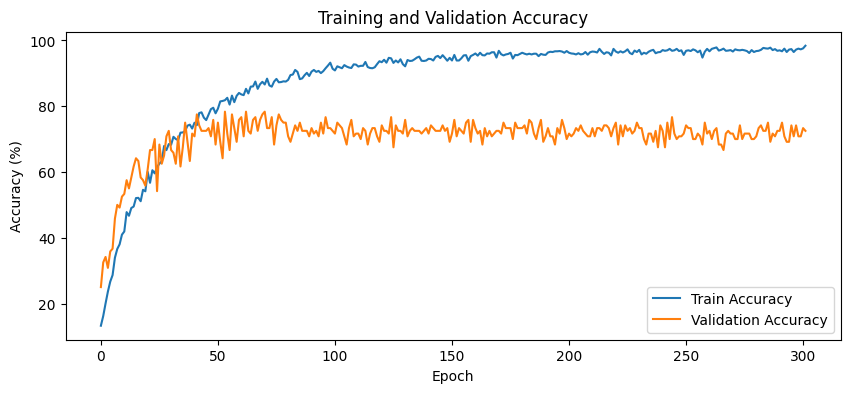

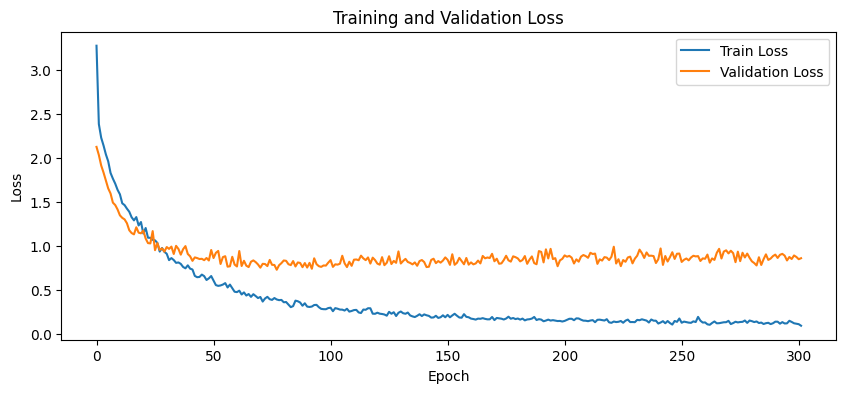

In [ ]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(False)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/genriflow_augment/accuracy_plot.pdf')
plt.show()

torch.save(model.state_dict(), save_path)
# Plot Loss
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(False)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/genriflow_augment/loss_plot.pdf')
plt.show()
metrics = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies
}

with open('/content/drive/MyDrive/Colab Notebooks/genriflow_augment/metrics.pkl', 'wb') as f:
    pickle.dump(metrics, f)

In [ ]:
# Evaluating the model
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
correct_preds = 0
total_preds = 0

with torch.no_grad():  # Disable gradient calculation during inference
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        test_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

test_accuracy = correct_preds / total_preds * 100
print(f'Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.8059, Test Accuracy: 72.50%


In [ ]:
# prompt: use the val_accuracies saved in metrics.pkl in genriflow_augment and genriflow folders to plot in the same figure. I want to compare the val error of augmentation with no augmentation. For epochs  after 100, calculate the average of each line and plot a horizontal line . also save the figure in pdf in the genriflow folder. Plot  the epochs until the first curve that stops and make the x-axis stop there. Move the legend towards the right bottom, inside the plot

import pickle
import matplotlib.pyplot as plt

# Load the metrics from the pickle files
with open('/content/drive/MyDrive/Colab Notebooks/genriflow/metrics.pkl', 'rb') as f:
    metrics_genriflow = pickle.load(f)

with open('/content/drive/MyDrive/Colab Notebooks/genriflow_augment/metrics.pkl', 'rb') as f:
    metrics_genriflow_augment = pickle.load(f)

# Extract the validation accuracies
val_accuracies_genriflow = metrics_genriflow['val_accuracies']
val_accuracies_genriflow_augment = metrics_genriflow_augment['val_accuracies']

# Find the minimum length of the two lists
min_len = min(len(val_accuracies_genriflow), len(val_accuracies_genriflow_augment))

# Truncate the lists to the minimum length
val_accuracies_genriflow = val_accuracies_genriflow[:min_len]
val_accuracies_genriflow_augment = val_accuracies_genriflow_augment[:min_len]

# Calculate the average of each line after 100 epochs
avg_genriflow = sum(val_accuracies_genriflow[100:]) / len(val_accuracies_genriflow[100:])
avg_genriflow_augment = sum(val_accuracies_genriflow_augment[100:]) / len(val_accuracies_genriflow_augment[100:])

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(val_accuracies_genriflow, label='Genriflow')
plt.plot(val_accuracies_genriflow_augment, label='Genriflow Augment')
plt.axhline(y=avg_genriflow, color='b', linestyle='--', label=f'Avg Genriflow: {avg_genriflow:.2f}')
plt.axhline(y=avg_genriflow_augment, color='orange', linestyle='--', label=f'Avg Genriflow Augment: {avg_genriflow_augment:.2f}')


# Set plot limits based on the shortest curve
plt.xlim(0, min_len -1)

# Customize the plot
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.title('Comparison of Validation Accuracy with and without Augmentation')

# Move the legend to the right bottom inside the plot
plt.legend(loc='lower right')


plt.grid(True)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/genriflow/accuracy_comparison.pdf')
plt.show()
